# Introductory Notebook 4: Customizing MCD

This notebook will discuss methods for customizing MCD.

In [1]:
import sys
sys.path.append('../src/')
from decode_mcd import mcd_problem
from decode_mcd import mcd_dataset


from decode_mcd import design_targets
from decode_mcd import mcd_generator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

We'll use the example from Notebook 3 with a pure constraint-based counterfactuals problem featuring five discrete constraint-satisfying regions. Here is the function and a plot. 

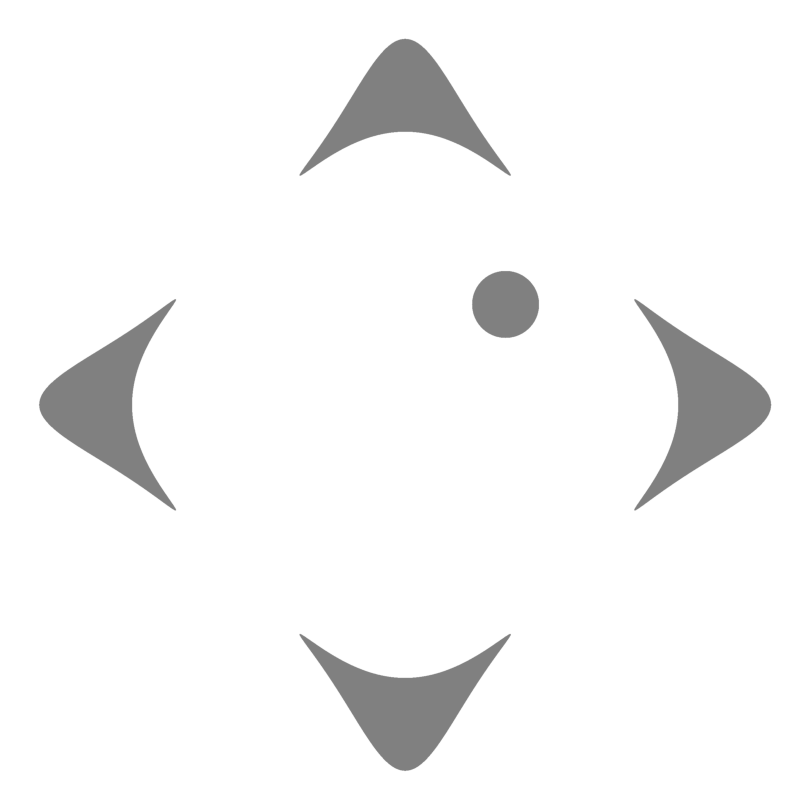

In [2]:
def validity(x): #Validity function for the 2D case
    x = np.array(x)
    x1 = x[:,0] #Separate the two dimensions for clarity
    x2 = x[:,1]
    fc = np.less(np.sqrt(np.power((x1-0.3), 2) + np.power((x2-0.3), 2)), 0.1) #Circle
    sc = np.less(np.power(np.power(np.power((x1-x2), 6)-1, 2) + np.power(np.power((x1+x2), 6)-1, 2), 2), 0.99) #Arcs
    union = np.logical_or(fc, sc) #If points are in circle or arcs they are valid
    y = union.reshape(-1,1) #reshaping here is important. We need to return a 2D array. 
    return y

def plot_validity(validity, rangearr):
    xx, yy = np.mgrid[rangearr[0,0]:rangearr[0,1]:.001, rangearr[1,0]:rangearr[1,1]:.001]
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = validity(grid)
    Z = np.array(Z)
    Z = Z.reshape(xx.shape)
    fig, ax = plt.subplots(1, 1, figsize=(5,5), dpi=200)
    img = ax.imshow(1-Z.T, cmap="gray", alpha=0.5, origin='lower', extent = rangearr.flatten())
    ax.axis('off')
    return ax

ranges = np.array([[-1.15, 1.15], [-1.15, 1.15]])

ax = plot_validity(validity, ranges)
plt.show()

We generate the data just as we did in Notebook 3. We go ahead and create the `McdDataset` and `McdProblem` as before.

In [3]:
x = np.random.rand(20000, 2) #Sample 10000 2D points
x = x*2.2-1.1 #Scale from -1.1 to 1.1

#Calculate the y values
y = validity(x)

x_query = np.zeros((1,2))

from pymoo.core.variable import Real, Integer, Choice, Binary 
datatypes=[Real(bounds=(-1.1, 1.1)), 
           Real(bounds=(-1.1, 1.1))]

data = mcd_dataset.McdDataset(x=x, y=y, x_datatypes=datatypes)

target_1 = design_targets.CategoricalTarget(label = 0, desired_classes=[True])

y_targets = design_targets.DesignTargets(categorical_targets=[target_1])

problem = mcd_problem.McdProblem(mcd_dataset=data, x_query = x_query, y_targets = y_targets, prediction_function=validity)

Before we run the counterfactuals search, let's change our counterfactual quality functions. As discussed in the paper, we optimize for proximity of the counterfactual to the query, sparsity of counterfactuall relative to the query, and manifold proximity of the counterfactual relative to the data manifold. By default, we implement these with gower distance, changed feature count, and average gower distance respectively. However depending on your needs, you may like to select other functions. For example, we can override the default gower distance for proximity with a dummy function. This function is configured to take in a set of counterfactuals (nxd dataframe) and the query (1xd dataframe), with n being some number of counterfactuals (usually batch_size) to evalaute and d being the nunber of features 

In [4]:
def dummy_fn(counterfactuals, query): #returns n zeros no matter what!
    return np.zeros(len(counterfactuals))

problem.set_proximity_function(dummy_fn)

generator = mcd_generator.McdGenerator(mcd_problem=problem, pop_size=100, initialize_from_dataset=False)

generator.generate(n_generations=100)

Initial population randomly initialized!
Training GA from 0 to 100 generations!
n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |       99 |      1 |  0.000000E+00 |  0.9100000000 |             - |             -
     2 |      199 |      1 |  0.000000E+00 |  0.6600000000 |  0.5000000000 |         ideal
     3 |      299 |      1 |  0.000000E+00 |  0.3600000000 |  0.000000E+00 |             f
     4 |      399 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0000872367 |             f
     5 |      499 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0006866039 |             f
     6 |      599 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0006866039 |             f
     7 |      699 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0006866039 |             f
     8 |      799 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0006866039 |             f
     9 |      899 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0006866039 |             f
    10 |  

Let's check what we get when we sample counterfactuals. Even if we set a high proximity weight, we don't get many samples from the circle because every counterfactual is equally proximal according to the proximity function we defined.

20000 dataset entries found matching problem parameters
Scoring all counterfactual candidates!
Calculating diversity matrix!
Sampling diverse set of counterfactual candidates!
samples_index=[np.int64(1855), np.int64(2413), np.int64(2085), np.int64(1772), np.int64(2289), np.int64(1947), np.int64(1762), np.int64(2225), np.int64(1944), np.int64(2612)]
Done! Returning CFs


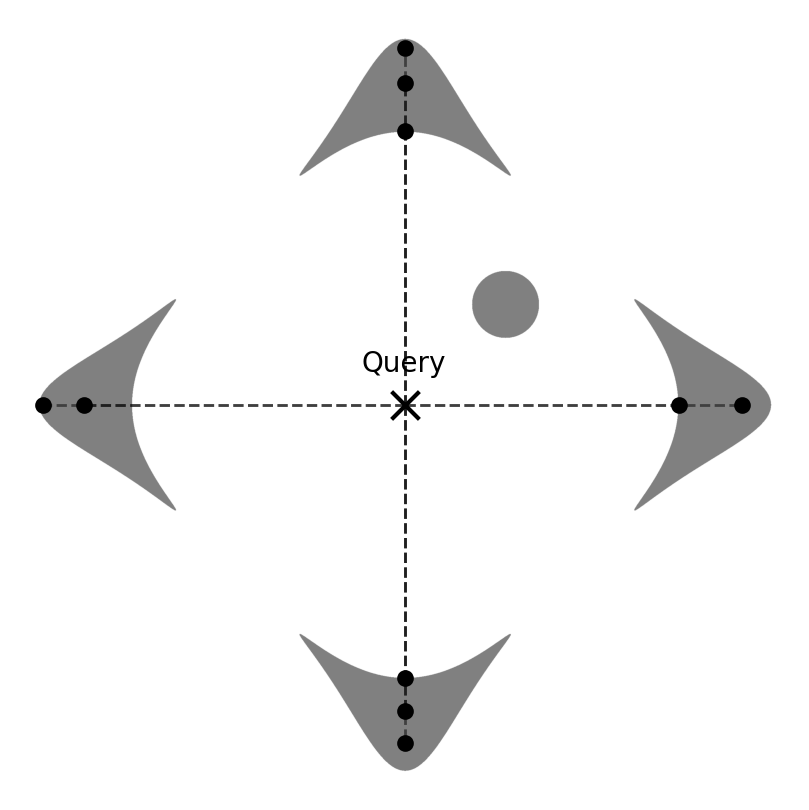

In [5]:
def plotcfs(validity, counterfactuals, x_query, rangearr, links=True): #plotting code from notebook 3
    counterfactuals = np.array(counterfactuals)
    query = x_query[0]
    ax = plot_validity(validity, rangearr)
    ax.scatter(query[0], query[1], s=100, c="k", alpha = 1, marker="x")
    ax.annotate("Query", (query[0]-.13, query[0]+0.1))
    if links: 
        ax.scatter(counterfactuals[:,0], counterfactuals[:,1], s=100, c="k", alpha = 1, marker=".")
        for i in range(np.shape(counterfactuals)[0]):
            ax.plot([query[0], counterfactuals[i,0]], [query[1], counterfactuals[i,1]],c = "k", linestyle="--", lw=1, alpha=0.5)
    else:
        ax.scatter(counterfactuals[:,0], counterfactuals[:,1], s=1, c="k", alpha = 1, marker=".")

default_cfs = generator.sample(num_samples=10, proximity_weight=100) #Set a high proximity weight

plotcfs(validity, default_cfs, x_query, ranges) #plot sampled counterfactuals

Sparsity is also a function of the counterfactual and the query. Let's try overriding the default sparsity function with our dummy function. 

In [6]:
problem.set_sparsity_function(dummy_fn)

generator = mcd_generator.McdGenerator(mcd_problem=problem, pop_size=100, initialize_from_dataset=False)

generator.generate(n_generations=100)

Initial population randomly initialized!
Training GA from 0 to 100 generations!
n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |       99 |      1 |  0.000000E+00 |  0.9200000000 |             - |             -
     2 |      199 |      1 |  0.000000E+00 |  0.7700000000 |  0.0044293260 |         ideal
     3 |      299 |      1 |  0.000000E+00 |  0.5100000000 |  0.0001561111 |             f
     4 |      399 |      1 |  0.000000E+00 |  0.2700000000 |  0.0009243505 |             f
     5 |      499 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0009243505 |             f
     6 |      599 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0009243505 |             f
     7 |      699 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0009243505 |             f
     8 |      799 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0020970081 |             f
     9 |      899 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0020970081 |             f
    10 |  

In this case both sparsity and proximity are ignored. 

20000 dataset entries found matching problem parameters
Scoring all counterfactual candidates!
Calculating diversity matrix!
Sampling diverse set of counterfactual candidates!
samples_index=[np.int64(232), np.int64(7034), np.int64(125), np.int64(1261), np.int64(719), np.int64(1022), np.int64(303), np.int64(374), np.int64(497), np.int64(1476)]
Done! Returning CFs


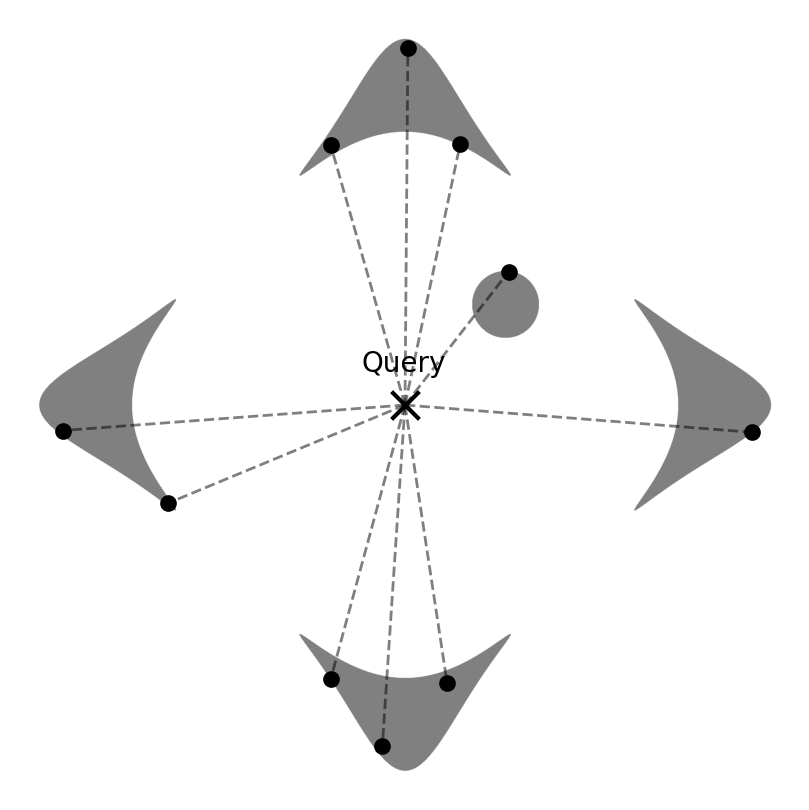

In [7]:
default_cfs = generator.sample(num_samples=10)

plotcfs(validity, default_cfs, x_query, ranges) #plot sampled counterfactuals

Ok, lets try to do something practical. Maybe instead of average gower distance, we want to evaluate manifold proximity using a kernel density estimator fitted on the valid entries of our dataset. Specifically, we will take the negative log likelihood of our KDE's density estimate. By convention, the manifold proximity function is a function of the counterfactuals (and not the query, as in proximity and sparsity). Lets take a look at our KDE

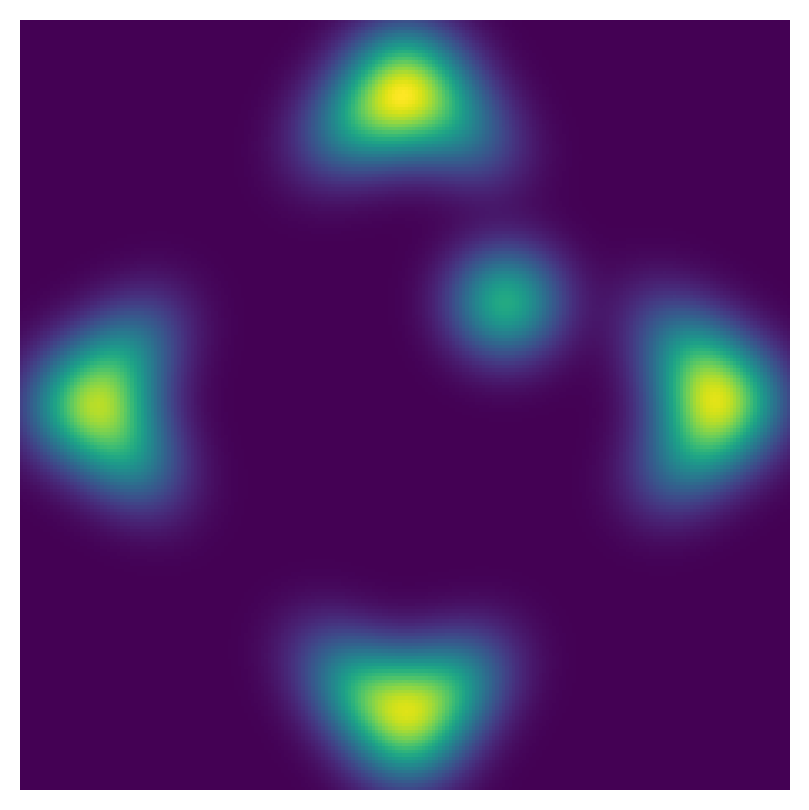

In [8]:
from sklearn.neighbors import KernelDensity
x_valid = x[y.flatten()]
kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(x_valid)

#plot kde
xx, yy = np.mgrid[ranges[0,0]:ranges[0,1]:.01, ranges[1,0]:ranges[1,1]:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
Z = np.exp(kde.score_samples(grid))
plt.figure(figsize=(5,5), dpi=200)
plt.imshow(Z.reshape(xx.shape).T, cmap="viridis", origin='lower', extent = ranges.flatten())
plt.axis('off')


def get_KDE_NLL_wrapper(kde):
    def KDE_NLL(counterfactuals, kde = kde):
        return -kde.score_samples(counterfactuals.values)
    return KDE_NLL


Ok, now lets override the manifold proximity function with our own and regenerate counterfactuals

In [9]:
problem.set_manprox_function(get_KDE_NLL_wrapper(kde))

generator = mcd_generator.McdGenerator(mcd_problem=problem, pop_size=100, initialize_from_dataset=False)

generator.generate(n_generations=100)

Initial population randomly initialized!
Training GA from 0 to 100 generations!
n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |       99 |      1 |  0.000000E+00 |  0.9300000000 |             - |             -
     2 |      199 |      1 |  0.000000E+00 |  0.7600000000 |  0.0425726818 |         ideal
     3 |      299 |      1 |  0.000000E+00 |  0.5300000000 |  0.0395596023 |         ideal
     4 |      399 |      1 |  0.000000E+00 |  0.3100000000 |  0.000000E+00 |             f
     5 |      499 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0021976621 |             f
     6 |      599 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0125827792 |         ideal
     7 |      699 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     8 |      799 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     9 |      899 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
    10 |  

We can take a look at the result. Since our original sampling was uniform, the KDE-based manifold proximity isn't doing a ton here, but in a different problem, this could have vastly different properties form the default average gower distance-based manifold proximity. 

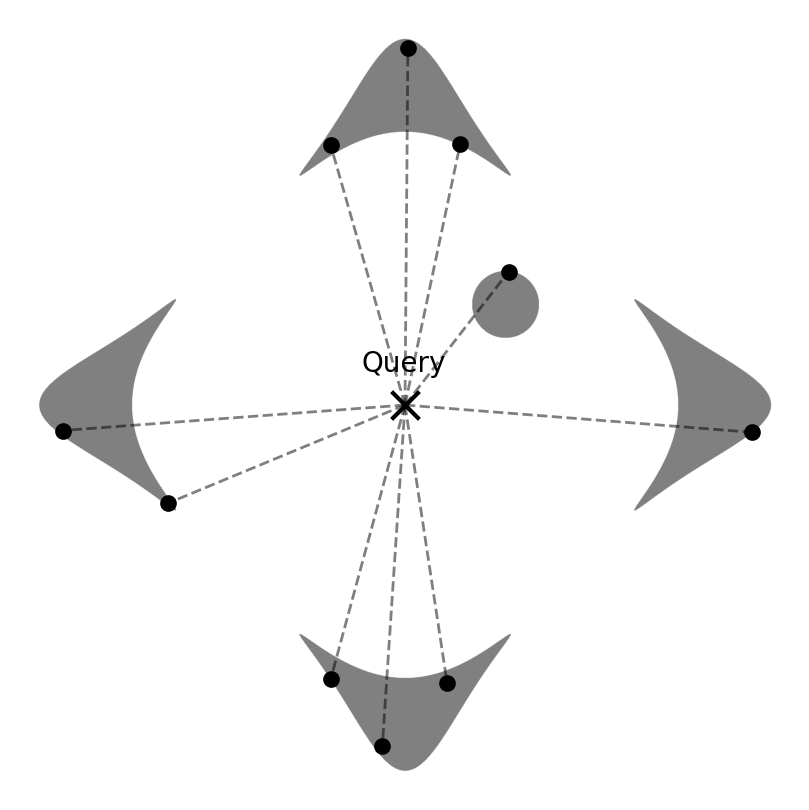

In [10]:
plotcfs(validity, default_cfs, x_query, ranges)

This concludes the final notebook of MCD's getting started series!